# Задача 3. Сравнение методов классификации

* **Дедлайн**: 21.11.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [ ] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [ ] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [ ] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

## 1. 

In [7]:
url = "https://raw.githubusercontent.com/rustam-azimov/ml-course/main/data/heart_disease/heart.csv"

try:
    df = pd.read_csv(url)
except Exception as e:
    print(f"{e}")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [8]:
print(f"Дубли: {df.duplicated().sum()}")

df = df.drop_duplicates()
print(f"без дубей: {df.shape}")

Дубли: 723
без дубей: (302, 14)


## 2. еда

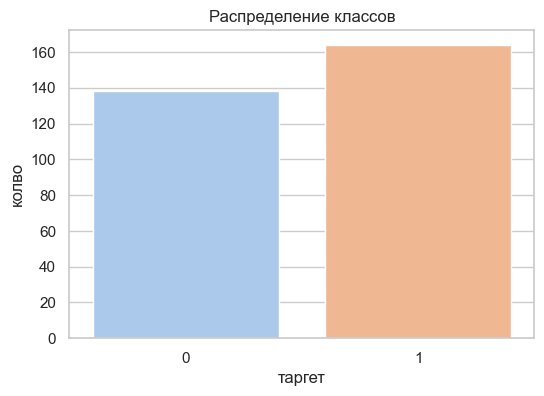

target
1    0.543046
0    0.456954
Name: proportion, dtype: float64


In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='pastel')
plt.title('Распределение классов')
plt.xlabel('таргет')
plt.ylabel('колво')
plt.show()

print(df['target'].value_counts(normalize=True))

ура классы сбалансированны

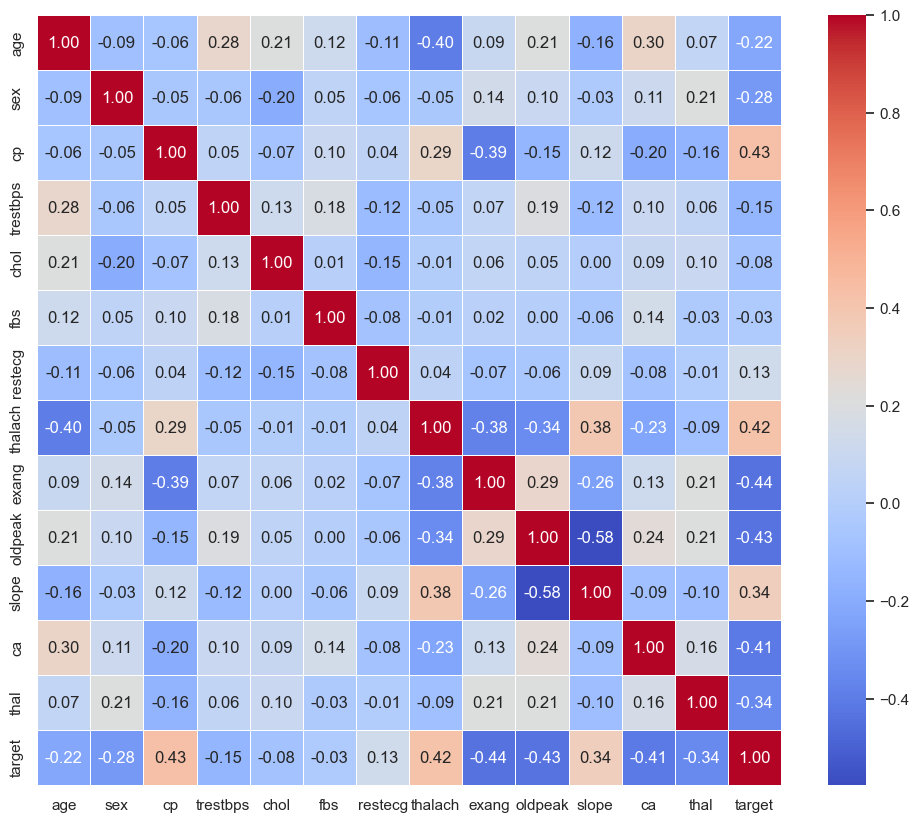

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

тагрет сильно коррелирует с `cp` и `thalach`

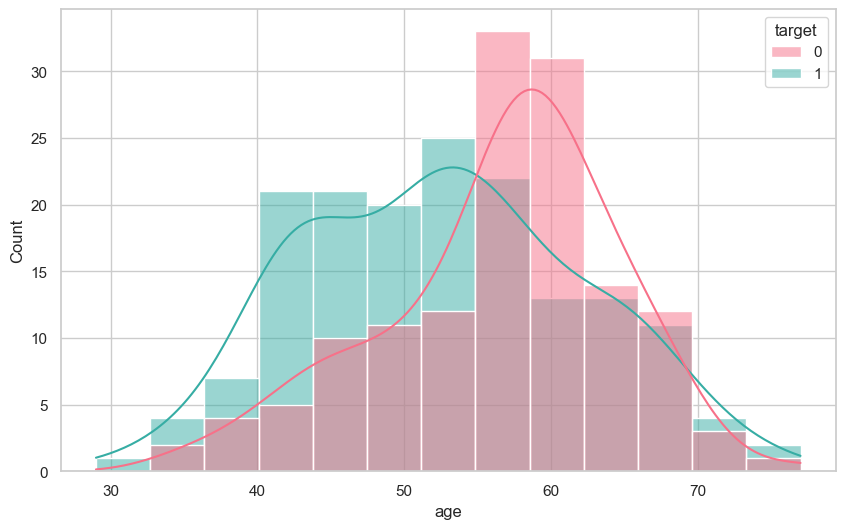

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='target', kde=True, palette='husl')
plt.show()

## 3. fe

In [ ]:
# категориальные, числовые и бинарные признаки
categorical_cols = ['cp', 'thal', 'slope']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
binary_cols = ['sex', 'fbs', 'exang', 'ca'] 

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(df_encoded.columns)

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'ca', 'target', 'cp_1', 'cp_2', 'cp_3', 'thal_1', 'thal_2',
       'thal_3', 'slope_1', 'slope_2'],
      dtype='object')


In [18]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## 4. Алгосы

кнн:

In [19]:
from collections import Counter

class CustomKNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

    def _predict_one(self, x):
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

my_knn = CustomKNN(n_neighbors=5)
my_knn.fit(X_train_scaled, y_train)
preds = my_knn.predict(X_test_scaled)
print(f"acc: {accuracy_score(y_test, preds):.4f}")

acc: 0.7869


регрессия:

In [20]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        X = np.array(X)
        y = np.array(y)

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

my_logreg = CustomLogisticRegression(learning_rate=0.1, n_iterations=1000)
my_logreg.fit(X_train_scaled, y_train)
log_preds = my_logreg.predict(X_test_scaled)
print(f"acc: {accuracy_score(y_test, log_preds):.4f}")

acc: 0.8197


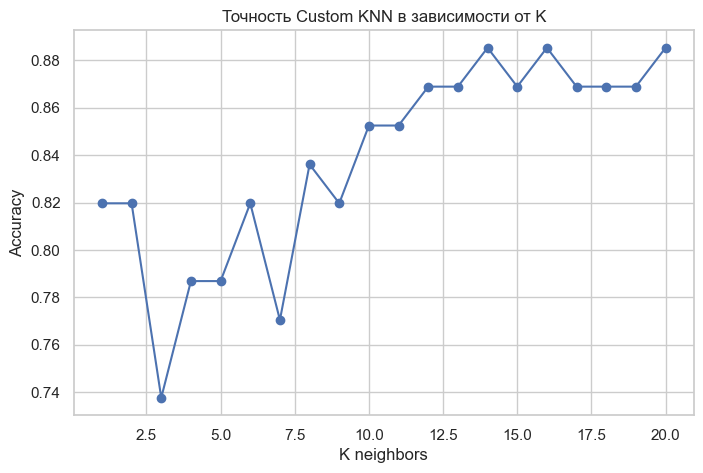

Лучший K для Custom KNN: 14 с точностью 0.8852


In [21]:
best_k = 3
best_acc = 0
accuracies = []

k_values = range(1, 21)

for k in k_values:
    knn = CustomKNN(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test_scaled))
    accuracies.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title('Точность Custom KNN в зависимости от K')
plt.xlabel('K neighbors')
plt.ylabel('Accuracy')
plt.show()

print(f"Лучший K для Custom KNN: {best_k} с точностью {best_acc:.4f}")

## 5. библиотечные реализации

In [22]:
models_results = {}

# 1. регрессия:
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
grid_lr = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)
models_results['LogReg (sklearn)'] = grid_lr.best_estimator_

# 2. кнн
knn_params = {'n_neighbors': list(range(3, 20)), 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
models_results['KNN (sklearn)'] = grid_knn.best_estimator_

# 3. свм
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_svm = GridSearchCV(SVC(probability=True), svm_params, cv=5, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)
models_results['SVM (sklearn)'] = grid_svm.best_estimator_

# 4. байес
nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_nb = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='accuracy')
grid_nb.fit(X_train_scaled, y_train)
models_results['Naive Bayes (sklearn)'] = grid_nb.best_estimator_

# 5. дерево решений
dt_params = {'max_depth': [None, 3, 5, 7, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
models_results['Decision Tree (sklearn)'] = grid_dt.best_estimator_


Обучение завершено.


In [23]:
models_results

{'LogReg (sklearn)': LogisticRegression(C=0.1),
 'KNN (sklearn)': KNeighborsClassifier(n_neighbors=15),
 'SVM (sklearn)': SVC(C=0.1, kernel='linear', probability=True),
 'Naive Bayes (sklearn)': GaussianNB(var_smoothing=np.float64(0.23101297000831597)),
 'Decision Tree (sklearn)': DecisionTreeClassifier(max_depth=3, random_state=42)}

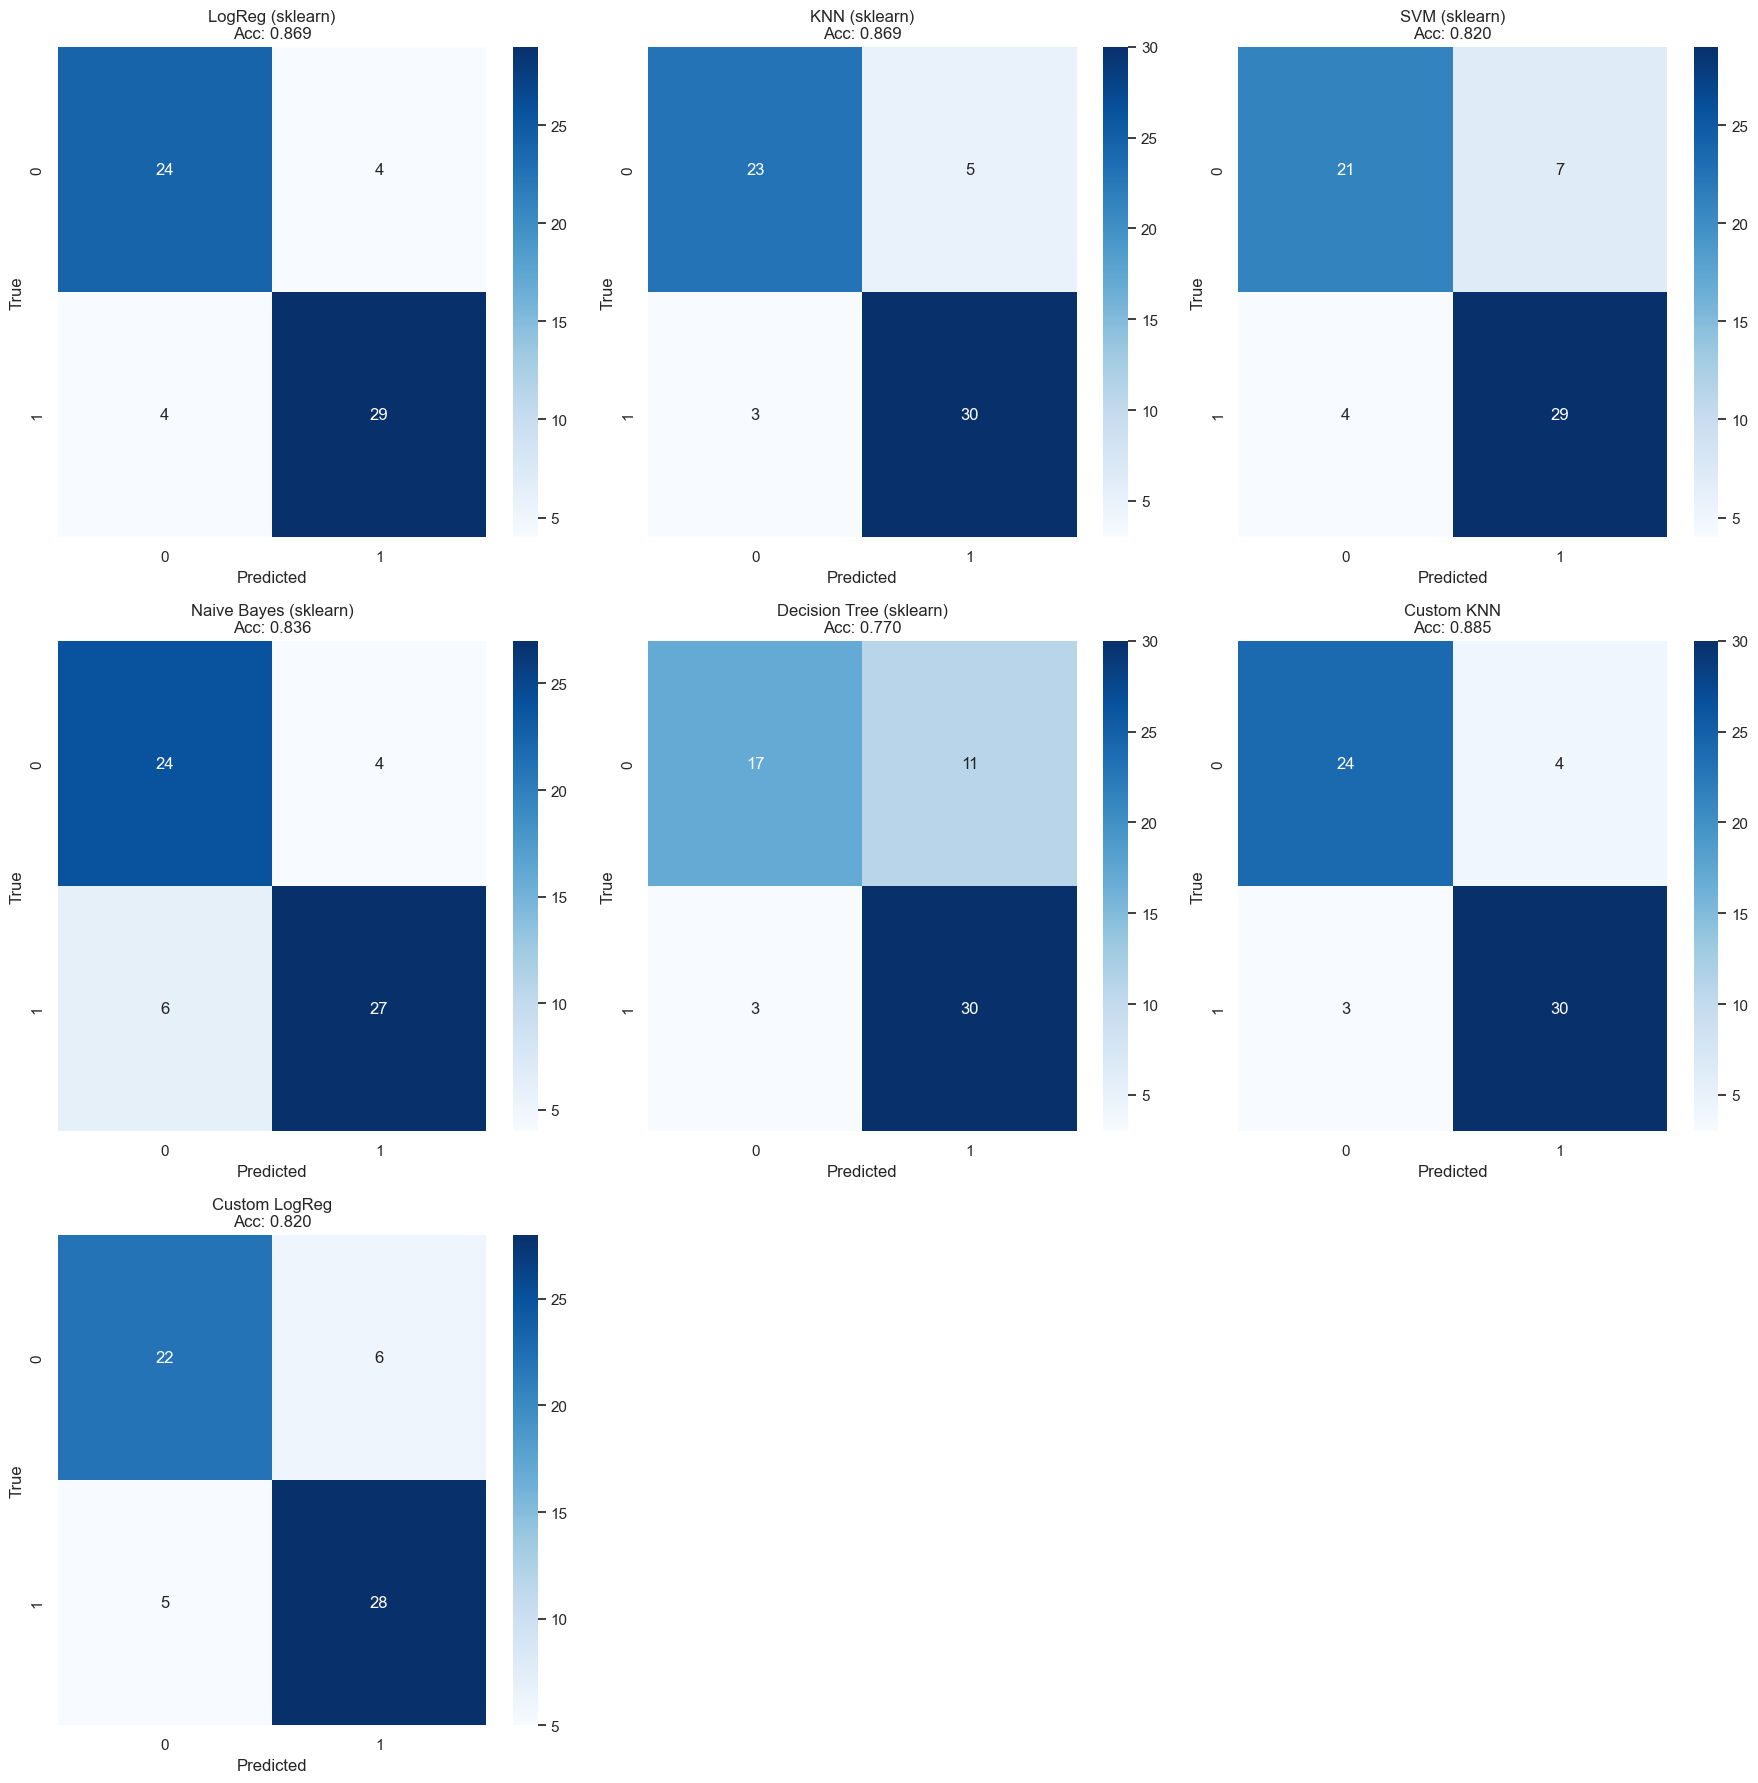


Итоговая таблица сравнения моделей:


,Model,Accuracy,F1-Score
5,Custom KNN,0.885246,0.895522
1,KNN (sklearn),0.868852,0.882353
0,LogReg (sklearn),0.868852,0.878788
3,Naive Bayes (sklearn),0.836066,0.843750
2,SVM (sklearn),0.819672,0.840580
6,Custom LogReg,0.819672,0.835821
4,Decision Tree (sklearn),0.770492,0.810811


In [ ]:
import math

metrics_data = []
custom_knn_best = CustomKNN(n_neighbors=best_k)
custom_knn_best.fit(X_train_scaled, y_train)

models_to_plot = list(models_results.items())
models_to_plot.append(('Custom KNN', custom_knn_best))
models_to_plot.append(('Custom LogReg', my_logreg))

num_models = len(models_to_plot)
n_cols = 3
n_rows = math.ceil(num_models / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

for i, (name, model) in enumerate(models_to_plot):
    if 'Tree' in name and 'sklearn' in name:
        X_val = X_test
    else:
        X_val = X_test_scaled

    y_pred = model.predict(X_val)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics_data.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1})

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}\nAcc: {acc:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(metrics_data).sort_values(by='Accuracy', ascending=False)
print("\nИтоговая таблица сравнения моделей:")
display(metrics_df)